In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [4]:
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

# Evaluation Functions

In [5]:
def smape(y, y_pred):
    
    div = (abs(y_pred) + abs(y)) / 2
    errors = abs(y_pred - y) / div
        
    smape = np.sum(errors) / len(y)
    return smape

def compute_avg_smape (df_y, df_y_pred):
    
    avg_smape = 0
    for i in range(df_y_pred.shape[1]):
        err = smape(y=df_y.iloc[:,i],
                              y_pred=df_y_pred.iloc[:,i])
        avg_smape += err

    avg_smape /= df_y_pred.shape[1]
    return avg_smape

In [20]:
df_one_one = df.loc[(df['store']==1) & (df['item']==1)]

In [21]:
df_one_one.shape

(1826, 4)

In [22]:
df_one_one.date.min(), df_one_one.date.max()

('2013-01-01', '2017-12-31')

# Data Exploration

In [26]:
df_one_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
date     1826 non-null object
store    1826 non-null int64
item     1826 non-null int64
sales    1826 non-null int64
dtypes: int64(3), object(1)
memory usage: 151.3+ KB


In [27]:
df_one_one['date'] = pd.to_datetime(df_one_one['date'])

In [28]:
df_one_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 4 columns):
date     1826 non-null datetime64[ns]
store    1826 non-null int64
item     1826 non-null int64
sales    1826 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 151.3 KB


In [29]:
cols=['store', 'item']
df_one_one.drop(cols,axis=1, inplace=True)

In [30]:
df_one_one = df_one_one.sort_values('date')

In [31]:
df_one_one = df_one_one.groupby('date')
df_one_one=df_one_one['sales'].sum().reset_index()
df_one_one = df_one_one.set_index('date')

In [32]:
df_one_one.shape

(1826, 1)

In [33]:
df_one_one.head()

sales
date             
2013-01-01     13
2013-01-02     11
2013-01-03     14
2013-01-04     13
2013-01-05     10

In [34]:
df_one_one.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

In [94]:
#y = df_one_one.squeeze()
y = df_one_one['sales'].resample('MS').mean()

In [95]:
y.head()

date
2013-01-01    10.580645
2013-02-01    11.500000
2013-03-01    15.387097
2013-04-01    17.400000
2013-05-01    17.129032
Freq: MS, Name: sales, dtype: float64

# Visualisations

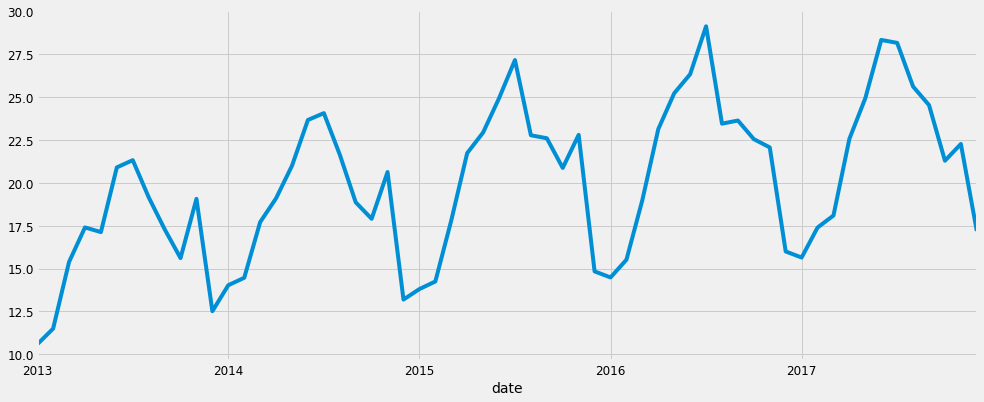

In [96]:
y.plot(figsize=(15,6))
plt.show()

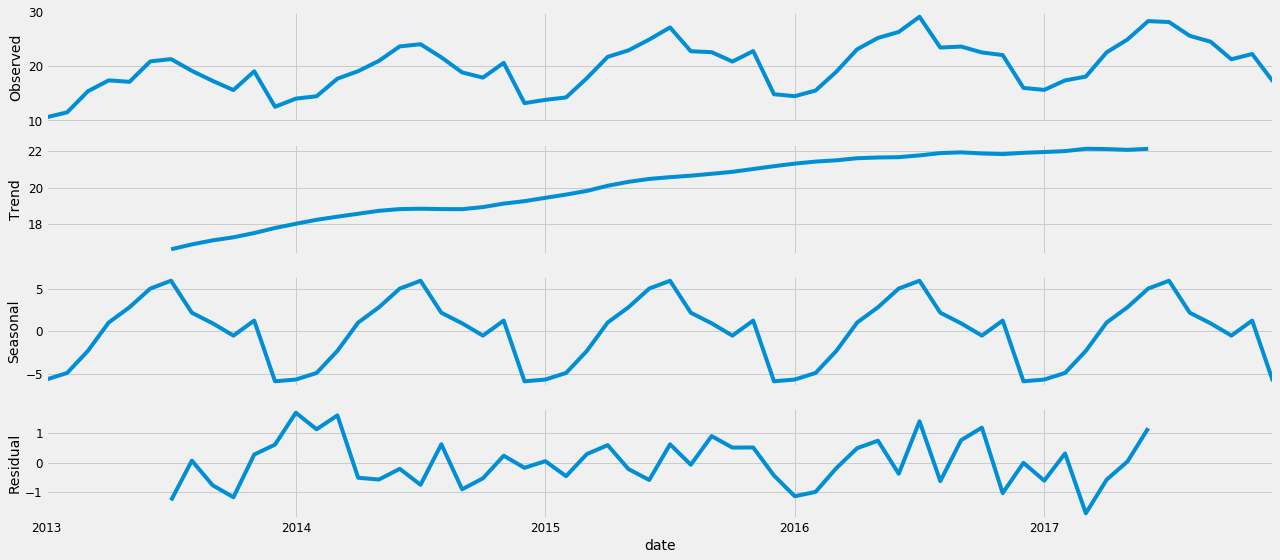

In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Time Series Forecasting with ARIMA

In [98]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:387.5719203826996


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1214.6523861647415
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:168.776589412485
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:163.9688851470119
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:125.85326363134035


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1344.2629477514677
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:455.8698594091882
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:331.33915377415536
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:173.16063029859396


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1331.6480547794213
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:171.51077669125323


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:160.63273192898873
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:126.84718784488668


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1349.8305773942855
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:206.47913942698483


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1450.598228293225
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:164.43411131196746
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:163.50012724742024
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:131.43036057060831


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1447.67249117988
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:291.2855596429274
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:203.61035836162824
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:144.40719166664755


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1424.528665472639
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:151.79233671598288
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:148.15767823555677


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:115.73915254574425


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1410.3654041643308
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:301.0309231480609
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:212.0211447092572
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:159.43973741098205


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1278.5591930477221
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:155.40231936599952
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:157.38562618068144
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:122.18362958572793


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1297.2181608495316
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:298.8266935231794
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:210.78673148270443
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:145.45629463441438


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1311.3724368865528
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:148.91415456055904
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:148.7905269071154
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:114.8641210768453


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1329.5547943212732
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:296.951797038932
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:208.45849126836538
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:152.86613154719475


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1505.1642278527238
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:154.211649570893
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:156.18673454758655
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:120.60899337991586


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1490.5134792419415
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:290.55003713507955
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:205.0934025178841
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:146.38810400030772


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1295.706030374586
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:150.98895893896915
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:150.15759874702695
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:112.9167814883065
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1281.5451618654988


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [99]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.675e-05      0.237      0.000      1.000      -0.465       0.465
ma.L1         -0.8558      0.108     -7.904      0.000      -1.068      -0.644
ar.S.L12   -5.799e-06      0.014     -0.000      1.000      -0.028       0.028
sigma2         1.2809      0.434      2.948      0.003       0.429       2.132


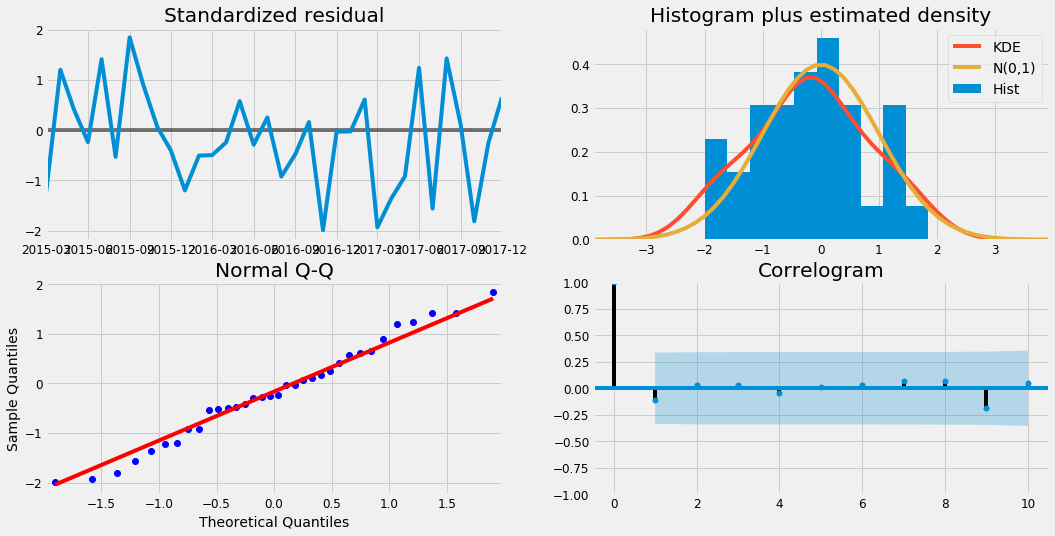

In [100]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts for 2017

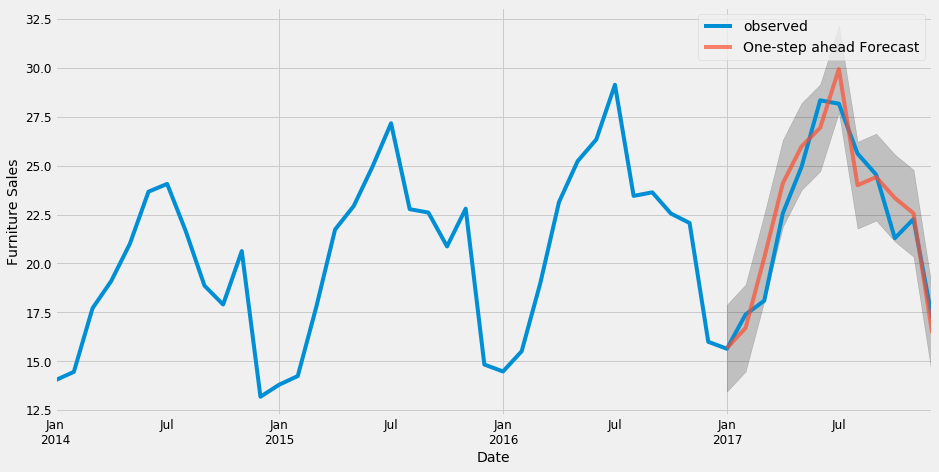

In [101]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [102]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1.77
The Root Mean Squared Error of our forecasts is 1.33


In [103]:
df_y_forecasted = pd.DataFrame(data=y_forecasted)

In [104]:
df_y_truth = pd.DataFrame(data=y['2017-01-01':])

In [105]:
df_y_forecasted.shape, df_y_truth.shape

((12, 1), (12, 1))

In [106]:
compute_avg_smape(df_y_truth,df_y_forecasted)

0.049500689021043626

In [107]:
y.sort_values(ascending=True)

date
2013-01-01    10.580645
2013-02-01    11.500000
2013-12-01    12.516129
2014-12-01    13.193548
2015-01-01    13.806452
2014-01-01    14.032258
2015-02-01    14.250000
2014-02-01    14.464286
2016-01-01    14.483871
2015-12-01    14.838710
2013-03-01    15.387097
2016-02-01    15.517241
2013-10-01    15.612903
2017-01-01    15.645161
2016-12-01    16.000000
2013-05-01    17.129032
2017-12-01    17.193548
2013-09-01    17.300000
2017-02-01    17.392857
2013-04-01    17.400000
2014-03-01    17.709677
2015-03-01    17.806452
2014-10-01    17.903226
2017-03-01    18.096774
2014-09-01    18.866667
2016-03-01    19.000000
2013-11-01    19.066667
2014-04-01    19.100000
2013-08-01    19.161290
2014-11-01    20.633333
2015-10-01    20.870968
2013-06-01    20.900000
2014-05-01    21.000000
2017-10-01    21.290323
2013-07-01    21.322581
2014-08-01    21.645161
2015-04-01    21.733333
2016-11-01    22.066667
2017-11-01    22.266667
2016-10-01    22.548387
2017-04-01    22.566667
2015-09-01 

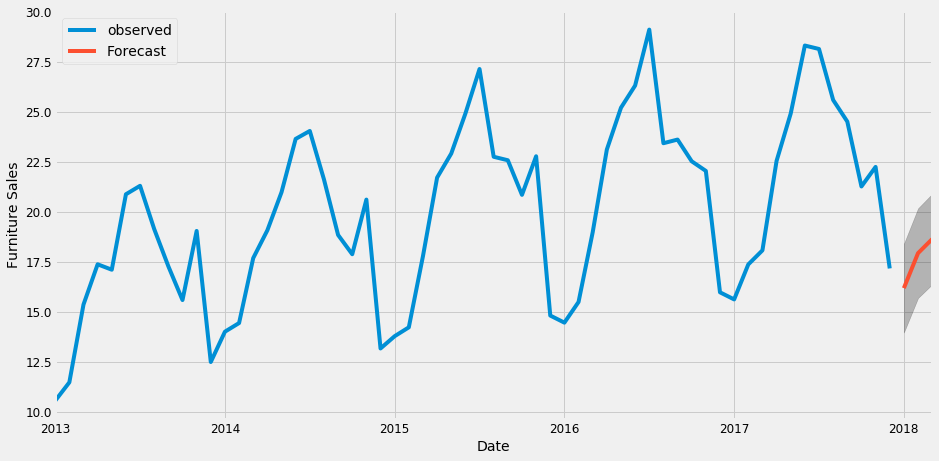

In [112]:
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [113]:
pred_uc

In [114]:
pred_uc_ci = pred_uc.conf_int(alpha=0.05)

In [115]:
pred_uc_ci

lower sales  upper sales
2018-01-01    13.990139    18.426517
2018-02-01    15.714867    20.197139
2018-03-01    16.396092    20.923780

In [49]:
test = pd.read_csv('data/test.csv')

In [50]:
test.head(10)

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1
5   5  2018-01-06      1     1
6   6  2018-01-07      1     1
7   7  2018-01-08      1     1
8   8  2018-01-09      1     1
9   9  2018-01-10      1     1

In [58]:
test.shape

(45000, 4)

In [118]:
test_one_one = test.loc[(test['store']==1) & (test['item']==1)] 

In [117]:
pred_uc_ci['median'] = (pred_uc_ci['lower sales'] + pred_uc_ci['upper sales'])/2

In [119]:
test_one_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 4 columns):
id       90 non-null int64
date     90 non-null object
store    90 non-null int64
item     90 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.5+ KB


In [120]:
test_one_one['date'] = pd.to_datetime(test_one_one['date'])

In [121]:
test_one_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 4 columns):
id       90 non-null int64
date     90 non-null datetime64[ns]
store    90 non-null int64
item     90 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.5 KB


In [130]:
pred_uc_ci.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2018-01-01 to 2018-03-01
Freq: MS
Data columns (total 3 columns):
lower sales    3 non-null float64
upper sales    3 non-null float64
median         3 non-null float64
dtypes: float64(3)
memory usage: 96.0 bytes


In [132]:
pred_uc_ci = pred_uc_ci.reset_index()

In [151]:
pred_uc_ci.rename(columns={'index':'date'}, inplace=True)

In [152]:
pred_uc_ci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
date           3 non-null datetime64[ns]
lower sales    3 non-null float64
upper sales    3 non-null float64
median         3 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 176.0 bytes


In [153]:
test_one_one['sales'] = ""

In [175]:
def make_predictions(test,pred):
    j = 0
    result = []
    for index, row in test.iterrows():
        if (pred.iloc[j].date.month == row.date.month):
            result.append(pred.iloc[j]['median'])
            
        else:
            j+=1
            result.append(pred.iloc[j]['median'])
    print (result)
    test_one_one['sales'] = result
    return test_one_one

In [158]:
pred_uc_ci.iloc[0].date.month

1

In [159]:
test_one_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 5 columns):
id       90 non-null int64
date     90 non-null datetime64[ns]
store    90 non-null int64
item     90 non-null int64
sales    90 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.2+ KB


In [160]:
pred_uc_ci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
date           3 non-null datetime64[ns]
lower sales    3 non-null float64
upper sales    3 non-null float64
median         3 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 176.0 bytes


In [176]:
test_one_one = make_predictions(test_one_one, pred_uc_ci)

[16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 16.208328139098231, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683, 17.956002986771683,

In [177]:
test_one_one

id       date  store  item      sales
0    0 2018-01-01      1     1  16.208328
1    1 2018-01-02      1     1  16.208328
2    2 2018-01-03      1     1  16.208328
3    3 2018-01-04      1     1  16.208328
4    4 2018-01-05      1     1  16.208328
5    5 2018-01-06      1     1  16.208328
6    6 2018-01-07      1     1  16.208328
7    7 2018-01-08      1     1  16.208328
8    8 2018-01-09      1     1  16.208328
9    9 2018-01-10      1     1  16.208328
10  10 2018-01-11      1     1  16.208328
11  11 2018-01-12      1     1  16.208328
12  12 2018-01-13      1     1  16.208328
13  13 2018-01-14      1     1  16.208328
14  14 2018-01-15      1     1  16.208328
15  15 2018-01-16      1     1  16.208328
16  16 2018-01-17      1     1  16.208328
17  17 2018-01-18      1     1  16.208328
18  18 2018-01-19      1     1  16.208328
19  19 2018-01-20      1     1  16.208328
20  20 2018-01-21      1     1  16.208328
21  21 2018-01-22      1     1  16.208328
22  22 2018-01-23      1     1  16.208328
23  23 2018-01-24      1     1  16.208328
24  24 2018-01-25      1     1  16.208328
25  25 2018-01-26      1     1  16.208328
26  26 2018-01-27      1     1  16.208328
27  27 2018-01-28      1     1  16.208328
28  28 2018-01-29      1     1  16.208328
29  29 2018-01-30      1     1  16.208328
..  ..        ...    ...   ...        ...
60  60 2018-03-02      1     1  18.659936
61  61 2018-03-03      1     1  18.659936
62  62 2018-03-04      1     1  18.659936
63  63 2018-03-05      1     1  18.659936
64  64 2018-03-06      1     1  18.659936
65  65 2018-03-07      1     1  18.659936
66  66 2018-03-08      1     1  18.659936
67  67 2018-03-09      1     1  18.659936
68  68 2018-03-10      1     1  18.659936
69  69 2018-03-11      1     1  18.659936
70  70 2018-03-12      1     1  18.659936
71  71 2018-03-13      1     1  18.659936
72  72 2018-03-14      1     1  18.659936
73  73 2018-03-15      1     1  18.659936
74  74 2018-03-16      1     1  18.659936
75  75 2018-03-17      1     1  18.659936
76  76 2018-03-18      1     1  18.659936
77  77 2018-03-19      1     1  18.659936
78  78 2018-03-20      1     1  18.659936
79  79 2018-03-21      1     1  18.659936
80  80 2018-03-22      1     1  18.659936
81  81 2018-03-23      1     1  18.659936
82  82 2018-03-24      1     1  18.659936
83  83 2018-03-25      1     1  18.659936
84  84 2018-03-26      1     1  18.659936
85  85 2018-03-27      1     1  18.659936
86  86 2018-03-28      1     1  18.659936
87  87 2018-03-29      1     1  18.659936
88  88 2018-03-30      1     1  18.659936
89  89 2018-03-31      1     1  18.659936

[90 rows x 5 columns]